In [44]:
### Standard Libraries Neccesary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import tensorflow as tf ## Includes Keras
import sklearn.metrics as metrics
import operator
import random
import os

## SKlearn methods
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble._forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Keras for neural net
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.utils.vis_utils import plot_model

### For conf matrix
import seaborn as sns

### For tree plotting
from sklearn import tree
from dtreeviz.trees import dtreeviz

# Learning Models for NHL Game Outcome Predictions
## with Sports Betting Applications

In this Jupyter Notebook we explore various machine learning models to evaluate NHL sports data and predict outcomes of matchups to apply to future matches with a hope to improve our informative sports betting outcomes.

Libraries used: **numpy, pandas, tensorflow, sklearn, keras**

Methods explored: **Logistic Regression, Neural Network, Random Forest**

Through these common classification models we hope to produce an effective model with relativly high accuracy to predict sports outcomes.

#### Potential Issues
Sports are relativly hard and complicated to predict. There is so much variability between matches including player injuries, home vs. away advantage, different matchups, penalties, and general unpredictability. The reason why machine learning models have often been unsuccessfully implemented in sports betting practices is because generally these models are rather innacurate because sports are difficult to predict.

#### Goals
Utilize classification models to produce outcomes with given probabilities of each team beating the given team. The raw win that a model would produce is not as important as we think. Say a team is always gonna beat another team like an absolute win everytime, it may not make sense to bet on that game because you likely wouldn't make money back. It would make more sense to bet on games with the probability of a team beating another team is rather narrow. The probabilities are essential for interpretation of these machine learning classification models to produce effective bets.

In [45]:
seed_value = 2022
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(2022)

## Loading Data and Differentiating Testing and Training Data
We will be creating our models based on NHL game and team data from October 2021 to present day. Our training data will be based on games and data from October 12th 2021 to April 3rd 2022. Our testing will be based on games and team data from April 4th 2022 to April 25th 2022. Each row of our data represents a game between two teams represented as Home or Visitor, the outcome of the game and goals score is included, additionally each team's stats is differentiated by Home or Visitor. Additionally elo data is included, elo was initially created as a measure of a chess player's skill but today it can be applied to any group to represent their skill level.

### Viewing Data

#### Training Data

In [46]:
train_data=pd.read_csv("modeling_data.csv", delimiter=',')
train_data=train_data.iloc[: , 1:]

In [47]:
pd.set_option('display.max_columns', None)
train_data.head()

,Date,Visitor,away_goals,Home,home_goals,AvAge_visitor,GP_visitor,W_visitor,L_visitor,OL_visitor,PTS_visitor,PTS_pct_visitor,GF_visitor,GA_visitor,SOW_visitor,SOL_visitor,SRS_visitor,SOS_visitor,GF_pctG_visitor,GA_pctG_visitor,PP_visitor,PPO_visitor,PP_pct_visitor,PPA_visitor,PPOA_visitor,PK_pct_visitor,SH_visitor,SHA_visitor,PIM_pctG_visitor,oPIM_pctG_visitor,S_visitor,S_pct_visitor,SA_visitor,SV_pct_visitor,SO_visitor,PDO_visitor,CF_visitor,CA_visitor,CF_pct_visitor,FF_visitor,FA_visitor,FF_pct_visitor,xGF_visitor,xGA_visitor,aGF_visitor,aGA_visitor,axDiff_visitor,SCF_visitor,SCA_visitor,SCF_pct_visitor,HDF_visitor,HDA_visitor,HDF_pct_visitor,HDGF_visitor,HDC_pct_visitor,HDGA_visitor,HDCO_pct_visitor,AvAge_home,GP_home,W_home,L_home,OL_home,PTS_home,PTS_pct_home,GF_home,GA_home,SOW_home,SOL_home,SRS_home,SOS_home,GF_pctG_home,GA_pctG_home,PP_home,PPO_home,PP_pct_home,PPA_home,PPOA_home,PK_pct_home,SH_home,SHA_home,PIM_pctG_home,oPIM_pctG_home,S_home,S_pct_home,SA_home,SV_pct_home,SO_home,PDO_home,CF_home,CA_home,CF_pct_home,FF_home,FA_home,FF_pct_home,xGF_home,xGA_home,aGF_home,aGA_home,axDiff_home,SCF_home,SCA_home,SCF_pct_home,HDF_home,HDA_home,HDF_pct_home,HDGF_home,HDC_pct_home,HDGA_home,HDCO_pct_home,Elo_visitor,Elo_home,home_win
0,2021-10-12,PITTSBURGH PENGUINS,6,TAMPA BAY LIGHTNING,2,29.6,74,42,22,10,94,0.635,240,199,3,6,0.49,-0.02,3.24,2.69,48,227,21.15,26,186,86.02,3,7,6.9,8.6,2558,9.4,2273,0.912,6,100.0,3461,3161,52.3,2673,2372,53.0,175.3,154.6,157,141,-5,1701,1478,53.5,489,452,52.0,73,13.0,62,12.1,29.5,72,44,20,8,96,0.667,237,199,2,5,0.48,-0.01,3.29,2.76,48,224,21.43,41,222,81.53,6,5,10.6,10.1,2200,10.8,2147,0.907,3,101.2,3014,2885,51.1,2324,2205,51.3,153.1,143.4,155,129,16,1588,1479,51.8,475,418,53.2,71,13.0,59,12.4,5439.333,5487.611,0
1,2021-10-12,SEATTLE KRAKEN,3,VEGAS GOLDEN KNIGHTS,4,28.9,72,23,43,6,52,0.361,184,249,2,1,-0.85,0.04,2.56,3.46,27,191,14.14,49,197,75.13,8,7,8.7,8.1,2081,8.8,2097,0.881,2,98.4,3051,3004,50.4,2266,2293,49.7,140.8,139.1,130,162,-34,1396,1451,49.0,413,445,48.1,37,8.2,68,13.3,28.4,73,40,29,4,84,0.575,230,215,4,1,0.22,-0.02,3.15,2.95,34,191,17.80,42,192,78.13,10,6,8.1,8.0,2481,9.3,2186,0.902,3,99.7,3500,3215,52.1,2623,2281,53.5,177.8,156.1,161,146,-7,1736,1604,52.0,579,516,52.9,77,11.7,71,12.1,3331.998,5395.163,1
2,2021-10-13,WINNIPEG JETS,1,ANAHEIM DUCKS,4,28.1,73,34,28,11,79,0.541,224,226,2,4,-0.06,-0.01,3.07,3.10,49,226,21.68,54,212,74.53,9,8,9.1,9.8,2367,9.5,2407,0.906,4,99.9,3179,3221,49.7,2417,2456,49.6,163.3,163.1,137,142,-5,1643,1656,49.8,513,525,49.4,64,11.1,56,9.6,27.8,74,29,33,12,70,0.473,204,237,4,5,-0.44,0.02,2.76,3.20,45,204,22.06,39,204,80.88,6,4,9.5,10.1,2191,9.3,2447,0.903,4,99.1,3167,3404,48.2,2404,2584,48.2,154.5,164.9,135,165,-20,1517,1623,48.3,475,473,50.1,65,12.0,54,10.2,5406.856,5252.777,1
3,2021-10-13,CHICAGO BLACKHAWKS,2,COLORADO AVALANCHE,4,28.1,72,24,37,11,59,0.410,188,253,4,2,-0.78,0.09,2.61,3.51,45,213,21.13,50,199,74.87,2,6,7.8,8.6,2077,9.1,2361,0.893,4,98.9,2924,3402,46.2,2132,2467,46.4,134.1,158.4,122,165,-19,1367,1642,45.4,359,450,44.4,46,11.4,70,13.5,28.2,72,52,14,6,110,0.764,271,197,4,1,0.99,-0.08,3.76,2.74,61,244,25.00,44,209,78.95,6,5,9.2,10.4,2543,10.7,2315,0.915,7,101.4,3328,2954,53.0,2423,2229,52.1,161.7,148.8,169,125,31,1601,1491,51.8,460,502,47.8,59,11.4,59,10.5,5282.785,5632.393,1
4,2021-10-13,VANCOUVER CANUCKS,2,EDMONTON OILERS,3,27.6,73,35,28,10,80,0.548,209,203,3,3,0.09,0.01,2.86,2.78,50,224,22.32,54,206,73.79,5,6,8.0,8.8,2348,8.9,2321,0.913,1,100.5,3220,3250,49.8,2396,2396,50.0,151.3,155.3,132,122,14,1576,1606,49.5,449,463,49.2,52,10.4,55,10.6,28.9,73,42,25,6,90,0.616,251,229,4,1,0.32,-0.02,3.44,3.14,54,212,25.47,50,224,77.68,9,6,8.0,7.1,2476,10.1,2332,0.902,2,99.9,3439,3112,52.5,2556,2408,51.5,169.1,161.8,160,155,-2,1630,1630,50.0,471,463,50.4,74,13.6,61,11.6,5456.211,5526.440,1


#### Testing Data

In [48]:
test_data=pd.read_csv("test_data.csv", delimiter=',')
test_data=test_data.iloc[: , 1:]

In [49]:
test_data.head()

,Date,Visitor,away_goals,Home,home_goals,home_win,AvAge_visitor,GP_visitor,W_visitor,L_visitor,OL_visitor,PTS_visitor,PTS_pct_visitor,GF_visitor,GA_visitor,SOW_visitor,SOL_visitor,SRS_visitor,SOS_visitor,GF_pctG_visitor,GA_pctG_visitor,PP_visitor,PPO_visitor,PP_pct_visitor,PPA_visitor,PPOA_visitor,PK_pct_visitor,SH_visitor,SHA_visitor,PIM_pctG_visitor,oPIM_pctG_visitor,S_visitor,S_pct_visitor,SA_visitor,SV_pct_visitor,SO_visitor,PDO_visitor,CF_visitor,CA_visitor,CF_pct_visitor,FF_visitor,FA_visitor,FF_pct_visitor,xGF_visitor,xGA_visitor,aGF_visitor,aGA_visitor,axDiff_visitor,SCF_visitor,SCA_visitor,SCF_pct_visitor,HDF_visitor,HDA_visitor,HDF_pct_visitor,HDGF_visitor,HDC_pct_visitor,HDGA_visitor,HDCO_pct_visitor,AvAge_home,GP_home,W_home,L_home,OL_home,PTS_home,PTS_pct_home,GF_home,GA_home,SOW_home,SOL_home,SRS_home,SOS_home,GF_pctG_home,GA_pctG_home,PP_home,PPO_home,PP_pct_home,PPA_home,PPOA_home,PK_pct_home,SH_home,SHA_home,PIM_pctG_home,oPIM_pctG_home,S_home,S_pct_home,SA_home,SV_pct_home,SO_home,PDO_home,CF_home,CA_home,CF_pct_home,FF_home,FA_home,FF_pct_home,xGF_home,xGA_home,aGF_home,aGA_home,axDiff_home,SCF_home,SCA_home,SCF_pct_home,HDF_home,HDA_home,HDF_pct_home,HDGF_home,HDC_pct_home,HDGA_home,HDCO_pct_home,Elo_visitor,Elo_home
0,2022-04-04,BOSTON BRUINS,3,COLUMBUS BLUE JACKETS,2,0,28.4,72,45,22,5,95,0.660,225,193,2,2,0.35,-0.09,3.13,2.68,47,209,22.49,40,230,82.61,5,6,10.1,9.8,2590,8.7,2070,0.907,3,99.1,3364,2838,54.2,2676,2140,55.6,170.0,126.4,152,130,-22,1602,1310,55.0,519,405,56.2,66,11.3,62,13.3,26.5,73,34,33,6,74,0.507,231,271,4,2,-0.48,0.04,3.16,3.71,33,192,17.19,45,211,78.67,7,6,7.7,7.0,2194,10.5,2598,0.896,2,99.9,3150,3484,47.5,2382,2723,46.7,142.8,190.9,160,195,13,1482,1719,46.3,424,487,46.5,67,13.6,63,11.5,5552.877,5372.810
1,2022-04-04,CALGARY FLAMES,3,LOS ANGELES KINGS,2,0,28.8,72,44,19,9,97,0.674,251,177,2,1,1.00,-0.04,3.49,2.46,47,203,23.15,35,216,83.80,7,3,9.1,8.4,2572,9.8,2105,0.916,11,101.0,3660,2880,56.0,2801,2226,55.7,175.4,133.6,171,119,10,1837,1400,56.8,524,407,56.3,58,10.0,46,10.2,27.9,74,38,26,10,86,0.581,208,210,4,4,0.00,0.03,2.81,2.84,38,226,16.81,47,201,76.62,11,9,7.5,8.4,2592,8.0,2128,0.901,5,98.4,3486,2956,54.1,2670,2224,54.6,161.4,152.0,132,137,-14,1760,1603,52.3,545,486,52.9,70,11.4,63,11.5,5526.116,5461.063
2,2022-04-04,ARIZONA COYOTES,1,ST. LOUIS BLUES,5,1,27.9,72,22,45,5,49,0.340,178,261,1,4,-1.17,0.03,2.47,3.63,24,177,13.56,59,219,73.06,3,4,10.4,8.4,1862,9.6,2551,0.898,1,100.1,2717,3472,43.9,2036,2654,43.4,129.2,179.0,136,182,4,1337,1703,44.0,415,547,43.1,58,12.3,75,12.1,28.7,72,42,20,10,94,0.653,262,204,2,3,0.74,-0.05,3.64,2.83,54,209,25.84,33,200,83.50,9,5,7.8,7.9,2201,11.9,2269,0.910,4,102.0,2883,3172,47.6,2230,2492,47.2,161.1,160.5,169,140,28,1619,1745,48.1,434,510,46.0,54,11.1,58,10.2,5288.365,5431.275
3,2022-04-04,TORONTO MAPLE LEAFS,6,TAMPA BAY LIGHTNING,2,0,28.3,72,47,19,6,100,0.694,275,220,2,1,0.71,-0.07,3.82,3.06,58,197,29.44,34,206,83.50,13,4,7.9,7.9,2504,11.0,2207,0.900,6,100.1,3514,3056,53.5,2658,2354,53.0,182.7,145.8,183,163,-17,1896,1557,54.9,543,434,55.6,69,11.3,68,13.5,29.5,72,44,20,8,96,0.667,237,199,2,5,0.48,-0.01,3.29,2.76,48,224,21.43,41,222,81.53,6,5,10.6,10.1,2200,10.8,2147,0.907,3,101.2,3014,2885,51.1,2324,2205,51.3,153.1,143.4,155,129,16,1588,1479,51.8,475,418,53.2,71,13.0,59,12.4,5556.285,5487.611
4,2022-04-05,CAROLINA HURRICANES,2,BUFFALO SABRES,4,1,28.3,73,47,18,8,102,0.699,242,173,1,2,0.90,-0.04,3.32,2.37,48,210,22.86,29,249,88.35,4,3,9.3,7.8,2462,9.8,2064,0.916,6,101.0,3540,2777,56.0,2712,2187,55.4,160.5,140.4,168,121,27,1681,1435,53.9,566,457,55.3,74,11.6,54,10.6,27.5,74,26,37,11,63,0.426,200,261,3,3,-0.78,0.05,2.70,3.53,40,197,20.30,46,185,75.14,4,6,8.1,7.7,2179,9.2,2486,0.895,1,99.2,3000,3324,47.4,2290,2644,46.4,136.5,168.5,141,179,-6,1367,1627,45.7,391,494,44.2,62,13.7,69,12.3,5498.348,5411.914


## Data Preprocessing

Our data fundamentally falls into a curse of dimensionality by having an absurd amount of columns on various sports statistics for both teams. We compared two logistic regression models fit on all the rows vs a processed version of the data with differentials between Home and Visitor data. The model fit with the differential data had a rather high improvement of accuracy so we will be performing processing to create a differential data set favoring the home team.

#### Train Data

In [50]:
dat = []
train_data_diff= pd.DataFrame(dat)

In [51]:
train_data_diff['Date']=train_data['Date']
train_data_diff['Home']=train_data['Home']
train_data_diff['home_goals']=train_data['home_goals']
train_data_diff['Visitor']=train_data['Visitor']
train_data_diff['away_goals']=train_data['away_goals']
train_data_diff['AvAge_diff']=train_data['AvAge_home']-train_data['AvAge_visitor']
train_data_diff['GP_diff']=train_data['GP_home']-train_data['GP_visitor']
train_data_diff['W_diff']=train_data['W_home']-train_data['W_visitor']
train_data_diff['L_diff']=train_data['L_home']-train_data['L_visitor']                             
train_data_diff['OL_diff'] = train_data['OL_home']-train_data['OL_visitor'] 
train_data_diff['PTS_diff']= train_data['PTS_home']-train_data['PTS_visitor']                             
train_data_diff['PTS_pct_diff']=train_data['PTS_pct_home']-train_data['PTS_pct_visitor']                             
train_data_diff['GF_diff']=train_data['GF_home']-train_data['GF_visitor']                             
train_data_diff['GA_diff']=train_data['GA_home']-train_data['GA_visitor']
train_data_diff['SOW_diff']=train_data['SOW_home']-train_data['SOW_visitor']
train_data_diff['SRS_diff']=train_data['SRS_home']-train_data['SRS_visitor']                             
train_data_diff['SOL_diff']=train_data['SOL_home']-train_data['SOL_visitor']                             
train_data_diff['SOS_diff']=train_data['SOS_home']-train_data['SOS_visitor']                             
train_data_diff['GF_pctG_diff']=train_data['GF_pctG_home']-train_data['GF_pctG_visitor']
train_data_diff['GA_pctG_diff']=train_data['GA_pctG_home']-train_data['GA_pctG_visitor']                             
train_data_diff['PP_diff']=train_data['PP_home']-train_data['PP_visitor']
train_data_diff['PPO_diff']=train_data['PPO_home']-train_data['PPO_visitor']                                
train_data_diff['PP_pct_diff']=train_data['PP_pct_home']-train_data['PP_pct_visitor']                                
train_data_diff['PPA_diff']=train_data['PPA_home']-train_data['PPA_visitor']                                
train_data_diff['PPOA_diff']=train_data['PPOA_home']-train_data['PPOA_visitor']
train_data_diff['PK_pct_diff']=train_data['PK_pct_home']-train_data['PK_pct_visitor']                                
train_data_diff['SH_diff']=train_data['SH_home']-train_data['SH_visitor']                                
train_data_diff['SHA_diff']=train_data['SHA_home']-train_data['SHA_visitor']                                
train_data_diff['PIM_pctG_diff']=train_data['PIM_pctG_home']-train_data['PIM_pctG_visitor']
train_data_diff['oPIM_pctG_diff']=train_data['oPIM_pctG_home']-train_data['oPIM_pctG_visitor']
train_data_diff['S_diff']=train_data['S_home']-train_data['S_visitor']
train_data_diff['S_pct_diff']=train_data['S_pct_home']-train_data['S_pct_visitor']                             
train_data_diff['SA_diff']=train_data['SA_home']-train_data['SA_visitor']                             
train_data_diff['SV_pct_diff']=train_data['SV_pct_home']-train_data['SV_pct_visitor']                             
train_data_diff['SO_diff']=train_data['SO_home']-train_data['SO_visitor'] 
train_data_diff['PDO_diff']=train_data['PDO_home']-train_data['PDO_visitor']                                  
train_data_diff['CF_diff']=train_data['CF_home']-train_data['CF_visitor']                                  
train_data_diff['CF_pct_diff']=train_data['CF_pct_home']-train_data['CF_pct_visitor']                                  
train_data_diff['FF_diff']=train_data['FF_home']-train_data['FF_visitor']                                  
train_data_diff['FA_diff']=train_data['FA_home']-train_data['FA_visitor'] 
train_data_diff['FF_pct_diff']=train_data['FF_pct_home']-train_data['FF_pct_visitor']                                  
train_data_diff['xGF_diff']=train_data['xGF_home']-train_data['xGF_visitor']                                  
train_data_diff['xGA_diff']=train_data['xGA_home']-train_data['xGA_visitor']                                  
train_data_diff['aGF_diff']=train_data['aGF_home']-train_data['aGF_visitor']                                  
train_data_diff['aGA_diff']=train_data['aGA_home']-train_data['aGA_visitor']   
train_data_diff['axDiff_diff']=train_data['axDiff_home']-train_data['axDiff_visitor']                                  
train_data_diff['SCF_diff']=train_data['SCF_home']-train_data['SCF_visitor']                                  
train_data_diff['SCA_diff']=train_data['SCA_home']-train_data['SCA_visitor']                                  
train_data_diff['SCF_pct_diff']=train_data['SCF_pct_home']-train_data['SCF_pct_visitor']
train_data_diff['HDF_diff']=train_data['HDF_home']-train_data['HDF_visitor']                                  
train_data_diff['HDA_diff']=train_data['HDA_home']-train_data['HDA_visitor']                                  
train_data_diff['HDF_pct_diff']=train_data['HDF_pct_home']-train_data['HDF_pct_visitor']                                  
train_data_diff['HDGF_diff']=train_data['HDGF_home']-train_data['HDGF_visitor']                                  
train_data_diff['HDC_pct_diff']=train_data['HDC_pct_home']-train_data['HDC_pct_visitor']                                  
train_data_diff['HDGA_diff']=train_data['HDGA_home']-train_data['HDGA_visitor']                                  
train_data_diff['HDCO_pct_diff']=train_data['HDCO_pct_home']-train_data['HDCO_pct_visitor']                                  
train_data_diff['Elo_diff']=train_data['Elo_home']-train_data['Elo_visitor']                                  
train_data_diff['home_win']=train_data['home_win']

In [52]:
train_data_diff.head()

,Date,Home,home_goals,Visitor,away_goals,AvAge_diff,GP_diff,W_diff,L_diff,OL_diff,PTS_diff,PTS_pct_diff,GF_diff,GA_diff,SOW_diff,SRS_diff,SOL_diff,SOS_diff,GF_pctG_diff,GA_pctG_diff,PP_diff,PPO_diff,PP_pct_diff,PPA_diff,PPOA_diff,PK_pct_diff,SH_diff,SHA_diff,PIM_pctG_diff,oPIM_pctG_diff,S_diff,S_pct_diff,SA_diff,SV_pct_diff,SO_diff,PDO_diff,CF_diff,CF_pct_diff,FF_diff,FA_diff,FF_pct_diff,xGF_diff,xGA_diff,aGF_diff,aGA_diff,axDiff_diff,SCF_diff,SCA_diff,SCF_pct_diff,HDF_diff,HDA_diff,HDF_pct_diff,HDGF_diff,HDC_pct_diff,HDGA_diff,HDCO_pct_diff,Elo_diff,home_win
0,2021-10-12,TAMPA BAY LIGHTNING,2,PITTSBURGH PENGUINS,6,-0.1,-2,2,-2,-2,2,0.032,-3,0,-1,-0.01,-1,0.01,0.05,0.07,0,-3,0.28,15,36,-4.49,3,-2,3.7,1.5,-358,1.4,-126,-0.005,-3,1.2,-447,-1.2,-349,-167,-1.7,-22.2,-11.2,-2,-12,21,-113,1,-1.7,-14,-34,1.2,-2,0.0,-3,0.3,48.278,0
1,2021-10-12,VEGAS GOLDEN KNIGHTS,4,SEATTLE KRAKEN,3,-0.5,1,17,-14,-2,32,0.214,46,-34,2,1.07,0,-0.06,0.59,-0.51,7,0,3.66,-7,-5,3.00,2,-1,-0.6,-0.1,400,0.5,89,0.021,1,1.3,449,1.7,357,-12,3.8,37.0,17.0,31,-16,27,340,153,3.0,166,71,4.8,40,3.5,3,-1.2,2063.165,1
2,2021-10-13,ANAHEIM DUCKS,4,WINNIPEG JETS,1,-0.3,1,-5,5,1,-9,-0.068,-20,11,2,-0.38,1,0.03,-0.31,0.10,-4,-22,0.38,-15,-8,6.35,-3,-4,0.4,0.3,-176,-0.2,40,-0.003,0,-0.8,-12,-1.5,-13,128,-1.4,-8.8,1.8,-2,23,-15,-126,-33,-1.5,-38,-52,0.7,1,0.9,-2,0.6,-154.079,1
3,2021-10-13,COLORADO AVALANCHE,4,CHICAGO BLACKHAWKS,2,0.1,0,28,-23,-5,51,0.354,83,-56,0,1.77,-1,-0.17,1.15,-0.77,16,31,3.87,-6,10,4.08,4,-1,1.4,1.8,466,1.6,-46,0.022,3,2.5,404,6.8,291,-238,5.7,27.6,-9.6,47,-40,50,234,-151,6.4,101,52,3.4,13,0.0,-11,-3.0,349.608,1
4,2021-10-13,EDMONTON OILERS,3,VANCOUVER CANUCKS,2,1.3,0,7,-3,-4,10,0.068,42,26,1,0.23,-2,-0.03,0.58,0.36,4,-12,3.15,-4,18,3.89,4,0,0.0,-1.7,128,1.2,11,-0.011,1,-0.6,219,2.7,160,12,1.5,17.8,6.5,28,33,-16,54,24,0.5,22,0,1.2,22,3.2,6,1.0,70.229,1


#### Test Data

In [53]:
test_data_diff= pd.DataFrame(dat)

In [54]:
test_data_diff['Date']=test_data['Date']
test_data_diff['Home']=test_data['Home']
test_data_diff['home_goals']=test_data['home_goals']
test_data_diff['Visitor']=test_data['Visitor']
test_data_diff['away_goals']=test_data['away_goals']
test_data_diff['AvAge_diff']=test_data['AvAge_home']-test_data['AvAge_visitor']
test_data_diff['GP_diff']=test_data['GP_home']-test_data['GP_visitor']
test_data_diff['W_diff']=test_data['W_home']-test_data['W_visitor']
test_data_diff['L_diff']=test_data['L_home']-test_data['L_visitor']                             
test_data_diff['OL_diff'] = test_data['OL_home']-test_data['OL_visitor'] 
test_data_diff['PTS_diff']= test_data['PTS_home']-test_data['PTS_visitor']                             
test_data_diff['PTS_pct_diff']=test_data['PTS_pct_home']-test_data['PTS_pct_visitor']                             
test_data_diff['GF_diff']=test_data['GF_home']-test_data['GF_visitor']                             
test_data_diff['GA_diff']=test_data['GA_home']-test_data['GA_visitor']
test_data_diff['SOW_diff']=test_data['SOW_home']-test_data['SOW_visitor']
test_data_diff['SRS_diff']=test_data['SRS_home']-test_data['SRS_visitor']                             
test_data_diff['SOL_diff']=test_data['SOL_home']-test_data['SOL_visitor']                             
test_data_diff['SOS_diff']=test_data['SOS_home']-test_data['SOS_visitor']                             
test_data_diff['GF_pctG_diff']=test_data['GF_pctG_home']-test_data['GF_pctG_visitor']
test_data_diff['GA_pctG_diff']=test_data['GA_pctG_home']-test_data['GA_pctG_visitor']                             
test_data_diff['PP_diff']=test_data['PP_home']-test_data['PP_visitor']
test_data_diff['PPO_diff']=test_data['PPO_home']-test_data['PPO_visitor']                                
test_data_diff['PP_pct_diff']=test_data['PP_pct_home']-test_data['PP_pct_visitor']                                
test_data_diff['PPA_diff']=test_data['PPA_home']-test_data['PPA_visitor']                                
test_data_diff['PPOA_diff']=test_data['PPOA_home']-test_data['PPOA_visitor']
test_data_diff['PK_pct_diff']=test_data['PK_pct_home']-test_data['PK_pct_visitor']                                
test_data_diff['SH_diff']=test_data['SH_home']-test_data['SH_visitor']                                
test_data_diff['SHA_diff']=test_data['SHA_home']-test_data['SHA_visitor']                                
test_data_diff['PIM_pctG_diff']=test_data['PIM_pctG_home']-test_data['PIM_pctG_visitor']
test_data_diff['oPIM_pctG_diff']=test_data['oPIM_pctG_home']-test_data['oPIM_pctG_visitor']
test_data_diff['S_diff']=test_data['S_home']-test_data['S_visitor']
test_data_diff['S_pct_diff']=test_data['S_pct_home']-test_data['S_pct_visitor']                             
test_data_diff['SA_diff']=test_data['SA_home']-test_data['SA_visitor']                             
test_data_diff['SV_pct_diff']=test_data['SV_pct_home']-test_data['SV_pct_visitor']                             
test_data_diff['SO_diff']=test_data['SO_home']-test_data['SO_visitor'] 
test_data_diff['PDO_diff']=test_data['PDO_home']-test_data['PDO_visitor']                                  
test_data_diff['CF_diff']=test_data['CF_home']-test_data['CF_visitor']                                  
test_data_diff['CF_pct_diff']=test_data['CF_pct_home']-test_data['CF_pct_visitor']                                  
test_data_diff['FF_diff']=test_data['FF_home']-test_data['FF_visitor']                                  
test_data_diff['FA_diff']=test_data['FA_home']-test_data['FA_visitor'] 
test_data_diff['FF_pct_diff']=test_data['FF_pct_home']-test_data['FF_pct_visitor']                                  
test_data_diff['xGF_diff']=test_data['xGF_home']-test_data['xGF_visitor']                                  
test_data_diff['xGA_diff']=test_data['xGA_home']-test_data['xGA_visitor']                                  
test_data_diff['aGF_diff']=test_data['aGF_home']-test_data['aGF_visitor']                                  
test_data_diff['aGA_diff']=test_data['aGA_home']-test_data['aGA_visitor']   
test_data_diff['axDiff_diff']=test_data['axDiff_home']-test_data['axDiff_visitor']                                  
test_data_diff['SCF_diff']=test_data['SCF_home']-test_data['SCF_visitor']                                  
test_data_diff['SCA_diff']=test_data['SCA_home']-test_data['SCA_visitor']                                  
test_data_diff['SCF_pct_diff']=test_data['SCF_pct_home']-test_data['SCF_pct_visitor']
test_data_diff['HDF_diff']=test_data['HDF_home']-test_data['HDF_visitor']                                  
test_data_diff['HDA_diff']=test_data['HDA_home']-test_data['HDA_visitor']                                  
test_data_diff['HDF_pct_diff']=test_data['HDF_pct_home']-test_data['HDF_pct_visitor']                                  
test_data_diff['HDGF_diff']=test_data['HDGF_home']-test_data['HDGF_visitor']                                  
test_data_diff['HDC_pct_diff']=test_data['HDC_pct_home']-test_data['HDC_pct_visitor']                                  
test_data_diff['HDGA_diff']=test_data['HDGA_home']-test_data['HDGA_visitor']                                  
test_data_diff['HDCO_pct_diff']=test_data['HDCO_pct_home']-test_data['HDCO_pct_visitor']                                  
test_data_diff['Elo_diff']=test_data['Elo_home']-test_data['Elo_visitor']                                  
test_data_diff['home_win']=test_data['home_win']

In [55]:
test_data_diff.head()

,Date,Home,home_goals,Visitor,away_goals,AvAge_diff,GP_diff,W_diff,L_diff,OL_diff,PTS_diff,PTS_pct_diff,GF_diff,GA_diff,SOW_diff,SRS_diff,SOL_diff,SOS_diff,GF_pctG_diff,GA_pctG_diff,PP_diff,PPO_diff,PP_pct_diff,PPA_diff,PPOA_diff,PK_pct_diff,SH_diff,SHA_diff,PIM_pctG_diff,oPIM_pctG_diff,S_diff,S_pct_diff,SA_diff,SV_pct_diff,SO_diff,PDO_diff,CF_diff,CF_pct_diff,FF_diff,FA_diff,FF_pct_diff,xGF_diff,xGA_diff,aGF_diff,aGA_diff,axDiff_diff,SCF_diff,SCA_diff,SCF_pct_diff,HDF_diff,HDA_diff,HDF_pct_diff,HDGF_diff,HDC_pct_diff,HDGA_diff,HDCO_pct_diff,Elo_diff,home_win
0,2022-04-04,COLUMBUS BLUE JACKETS,2,BOSTON BRUINS,3,-1.9,1,-11,11,1,-21,-0.153,6,78,2,-0.83,0,0.13,0.03,1.03,-14,-17,-5.30,5,-19,-3.94,2,0,-2.4,-2.8,-396,1.8,528,-0.011,-1,0.8,-214,-6.7,-294,583,-8.9,-27.2,64.5,8,65,35,-120,409,-8.7,-95,82,-9.7,1,2.3,1,-1.8,-180.067,0
1,2022-04-04,LOS ANGELES KINGS,2,CALGARY FLAMES,3,-0.9,2,-6,7,1,-11,-0.093,-43,33,2,-1.00,3,0.07,-0.68,0.38,-9,23,-6.34,12,-15,-7.18,4,6,-1.6,0.0,20,-1.8,23,-0.015,-6,-2.6,-174,-1.9,-131,-2,-1.1,-14.0,18.4,-39,18,-24,-77,203,-4.5,21,79,-3.4,12,1.4,17,1.3,-65.053,0
2,2022-04-04,ST. LOUIS BLUES,5,ARIZONA COYOTES,1,0.8,0,20,-25,5,45,0.313,84,-57,1,1.91,-1,-0.08,1.17,-0.80,30,32,12.28,-26,-19,10.44,6,1,-2.6,-0.5,339,2.3,-282,0.012,3,1.9,166,3.7,194,-162,3.8,31.9,-18.5,33,-42,24,282,42,4.1,19,-37,2.9,-4,-1.2,-17,-1.9,142.910,1
3,2022-04-04,TAMPA BAY LIGHTNING,2,TORONTO MAPLE LEAFS,6,1.2,0,-3,1,2,-4,-0.027,-38,-21,0,-0.23,4,0.06,-0.53,-0.30,-10,27,-8.01,7,16,-1.97,-7,1,2.7,2.2,-304,-0.2,-60,0.007,-3,1.1,-500,-2.4,-334,-149,-1.7,-29.6,-2.4,-28,-34,33,-308,-78,-3.1,-68,-16,-2.4,2,1.7,-9,-1.1,-68.674,0
4,2022-04-05,BUFFALO SABRES,4,CAROLINA HURRICANES,2,-0.8,1,-21,19,3,-39,-0.273,-42,88,2,-1.68,1,0.09,-0.62,1.16,-8,-13,-2.56,17,-64,-13.21,0,3,-1.2,-0.1,-283,-0.6,422,-0.021,-5,-1.8,-540,-8.6,-422,457,-9.0,-24.0,28.1,-27,58,-33,-314,192,-8.2,-175,37,-11.1,-12,2.1,15,1.7,-86.434,1


### Defining Training, Testing split

In [56]:
X_train = train_data_diff.drop(columns = ['Date','Visitor','Home','home_win','away_goals','home_goals'])
y_train = train_data_diff[['home_win']] 
X_test = test_data_diff.drop(columns = ['Date','Visitor','Home','home_win','away_goals','home_goals'])
y_test = test_data_diff[['home_win']]

### Function to Display Probability of Outcomes between two teams
This function was defined to display all the probabilities of matchups between two teams in a given data set given the model predictions.

In [57]:
def display(y_pred,test):#### takes two inputs, the vectors of the predicted y values, and the testing dataframe 
    for g in range(len(y_pred)):
        win_prob = np.round(y_pred[g],2) ### takes the predicted probability and rounds
        away_team = test.reset_index().drop(columns = 'index').loc[g,'Visitor'] # gains name of the away team
        home_team = test.reset_index().drop(columns = 'index').loc[g,'Home'] # gains name of the home team
        print(f'The {home_team} have a probability of {win_prob} of beating the {away_team}.') #output probability of home beating away

# Logistic Regression

### Model Fitting and Training

In [58]:
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

clf = LogisticRegression(penalty='l1', dual=False, tol=0.001, C=1.0, fit_intercept=True, 
                   intercept_scaling=1, class_weight='balanced', random_state=None, 
                   solver='liblinear', max_iter=1000, multi_class='ovr', verbose=0)

clf.fit(X_train, np.ravel(y_train.values))

LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='ovr',
                   penalty='l1', solver='liblinear', tol=0.001)

### Predicting and applying test data, producing accuracy score

In [59]:
y_pred = clf.predict_proba(X_test)
y_pred = y_pred[:,1]
print("Accuracy of Logistic Regression Model: ", accuracy_score(y_test,np.round(y_pred)))

Accuracy of Logistic Regression Model:  0.6809815950920245


### Displaying probabilities of Test Data

In [60]:
display(y_pred,test_data_diff)

The COLUMBUS BLUE JACKETS have a probability of 0.35 of beating the BOSTON BRUINS.
The LOS ANGELES KINGS have a probability of 0.46 of beating the CALGARY FLAMES.
The ST. LOUIS BLUES have a probability of 0.74 of beating the ARIZONA COYOTES.
The TAMPA BAY LIGHTNING have a probability of 0.49 of beating the TORONTO MAPLE LEAFS.
The BUFFALO SABRES have a probability of 0.22 of beating the CAROLINA HURRICANES.
The DALLAS STARS have a probability of 0.63 of beating the NEW YORK ISLANDERS.
The DETROIT RED WINGS have a probability of 0.27 of beating the BOSTON BRUINS.
The FLORIDA PANTHERS have a probability of 0.57 of beating the TORONTO MAPLE LEAFS.
The MONTREAL CANADIENS have a probability of 0.4 of beating the OTTAWA SENATORS.
The NEW JERSEY DEVILS have a probability of 0.24 of beating the NEW YORK RANGERS.
The NASHVILLE PREDATORS have a probability of 0.44 of beating the MINNESOTA WILD.
The PHILADELPHIA FLYERS have a probability of 0.36 of beating the COLUMBUS BLUE JACKETS.
The PITTSBURG

### Analysis

The relative simplicity of a Logistic Regression model does not rule it out of being a worthy candidate of sports prediction for an emphasis on sports betting. A **68.1%** accuracy is quite effective and the provided probabilities can provide a lot of information for informed and accurate bets. The logistic decision function enables effective binary outcomes to be predicted with ease so this model cannot be discounted.

# Binary Classification Neural Network

### Model Fitting and Training

In [61]:
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

# construct model with idea network architecture
model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu'))#first layer input all features with relu activation
model.add(Dense(256, activation='tanh')) #tanh activation layer greatly improved accuracy
model.add(Dense(256, activation='relu')) #followed by another relu layer
model.add(Dense(1, activation='sigmoid')) #finally a sigmoid layer with a single output to detirmine a win prediction
model.summary() 

# model compiled with ADAM optimization using binary aspect
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])


# early stopping function to avoid over fitting
# will run for an additional 20 epochs after validation converges

es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max',
                                   patience=20,
                                   restore_best_weights=True)

# model training
history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=500, 
                    batch_size=10,
                    validation_split=0.1,
                    shuffle=False,
                    verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               27136     
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 224,513
Trainable params: 224,513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
100/100 [==============================] - 2s 7ms/step - loss: 0.7498 - accuracy: 0.5734 - val_loss: 0.7317 - val_accuracy: 0.4955
Epoch 2/500
100/100 [================

### Training and Validation Accuracy Traced

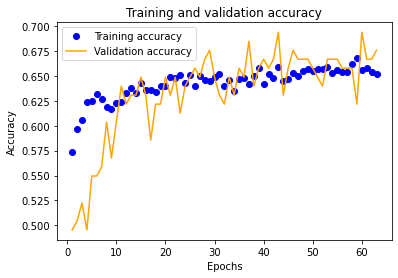

In [62]:
# accuracy and validation accuracy traced
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
n = range(1, len(acc) + 1) ## number of epochs

plt.plot(n, acc, 'bo', label='Training accuracy')
plt.plot(n, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion Matrix on Testing Data

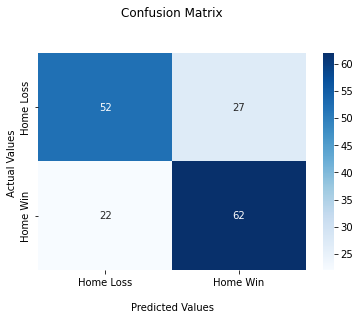

In [63]:
preds = np.round(model.predict(X_test),0)
# confusion matrix
cf_matrix = confusion_matrix(y_test, preds)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Home Loss','Home Win'])
ax.yaxis.set_ticklabels(['Home Loss','Home Win'])
## Display the visualization of the Confusion Matrix.
plt.show()

### Predicting and applying test data, producing accuracy score

In [64]:
y_pred = model.predict(X_test)
print("Accuracy of Neural Network Classification: ", accuracy_score(y_test,np.round(y_pred)))

Accuracy of Neural Network Classification:  0.6993865030674846


### Displaying probabilities of Test Data

In [65]:
display(y_pred,test_data_diff)

The COLUMBUS BLUE JACKETS have a probability of [0.43] of beating the BOSTON BRUINS.
The LOS ANGELES KINGS have a probability of [0.39] of beating the CALGARY FLAMES.
The ST. LOUIS BLUES have a probability of [0.72] of beating the ARIZONA COYOTES.
The TAMPA BAY LIGHTNING have a probability of [0.57] of beating the TORONTO MAPLE LEAFS.
The BUFFALO SABRES have a probability of [0.44] of beating the CAROLINA HURRICANES.
The DALLAS STARS have a probability of [0.67] of beating the NEW YORK ISLANDERS.
The DETROIT RED WINGS have a probability of [0.44] of beating the BOSTON BRUINS.
The FLORIDA PANTHERS have a probability of [0.69] of beating the TORONTO MAPLE LEAFS.
The MONTREAL CANADIENS have a probability of [0.48] of beating the OTTAWA SENATORS.
The NEW JERSEY DEVILS have a probability of [0.32] of beating the NEW YORK RANGERS.
The NASHVILLE PREDATORS have a probability of [0.43] of beating the MINNESOTA WILD.
The PHILADELPHIA FLYERS have a probability of [0.21] of beating the COLUMBUS BL

### Analysis

The Binary Classification Neural Network is probably the most adaptive model as we see it's effectivness in predicting the test data with an accuracy rate of **69.4%**. Though this model may take longer to run it has consistently produced the highest accuracy rates regardless of testing/training splits of the data. After tuning the parameters for this neural network for several hours, we discovered that the current network architecture was the best for predicting NHL sports outcomes. The provided probabilities also make this an effective model for sports betting.

# Random Forest Classification

### Model Fitting and Training

In [66]:
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

rfm=RandomForestClassifier(n_estimators=52, oob_score=True, n_jobs=-1,
                          random_state=2022, max_features =None, min_samples_leaf=30)
rfm.fit(X_train, y_train)

C:\Users\npicc\AppData\Local\Temp/ipykernel_12492/3839016152.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfm.fit(X_train, y_train)


RandomForestClassifier(max_features=None, min_samples_leaf=30, n_estimators=52,
                       n_jobs=-1, oob_score=True, random_state=2022)

### Visualizing Decision Tree

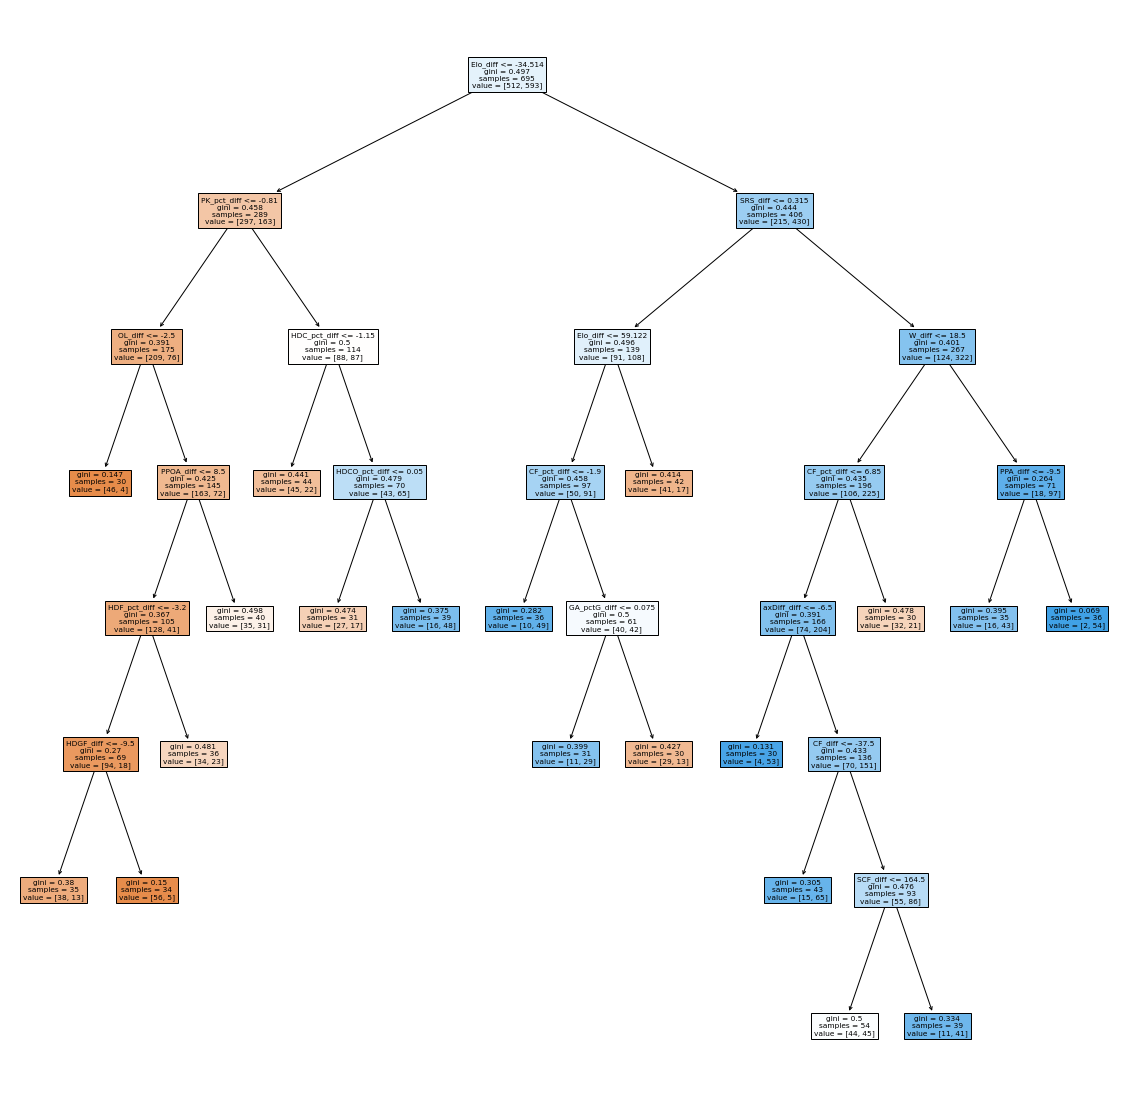

In [67]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(rfm.estimators_[0], feature_names=X_train.columns, filled=True)

### Confusion Matrix on Testing Data

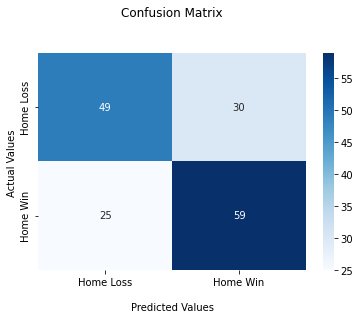

In [68]:
preds = np.round(rfm.predict(X_test),0)
# confusion matrix
cf_matrix = confusion_matrix(y_test, preds)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Home Loss','Home Win'])
ax.yaxis.set_ticklabels(['Home Loss','Home Win'])
## Display the visualization of the Confusion Matrix.
plt.show()

### Predicting and applying test data, producing accuracy score

In [69]:
y_pred = rfm.predict(X_test)
print("Accuracy of Random Forest Classifier: ", accuracy_score(y_test,np.round(y_pred)))

Accuracy of Random Forest Classifier:  0.6625766871165644


### Displaying probabilities of Test Data

In [70]:
y_pred = rfm.predict_proba(X_test)
y_pred = y_pred[:,1]
display(y_pred,test_data_diff)

The COLUMBUS BLUE JACKETS have a probability of 0.21 of beating the BOSTON BRUINS.
The LOS ANGELES KINGS have a probability of 0.34 of beating the CALGARY FLAMES.
The ST. LOUIS BLUES have a probability of 0.67 of beating the ARIZONA COYOTES.
The TAMPA BAY LIGHTNING have a probability of 0.41 of beating the TORONTO MAPLE LEAFS.
The BUFFALO SABRES have a probability of 0.26 of beating the CAROLINA HURRICANES.
The DALLAS STARS have a probability of 0.6 of beating the NEW YORK ISLANDERS.
The DETROIT RED WINGS have a probability of 0.15 of beating the BOSTON BRUINS.
The FLORIDA PANTHERS have a probability of 0.65 of beating the TORONTO MAPLE LEAFS.
The MONTREAL CANADIENS have a probability of 0.5 of beating the OTTAWA SENATORS.
The NEW JERSEY DEVILS have a probability of 0.33 of beating the NEW YORK RANGERS.
The NASHVILLE PREDATORS have a probability of 0.45 of beating the MINNESOTA WILD.
The PHILADELPHIA FLYERS have a probability of 0.26 of beating the COLUMBUS BLUE JACKETS.
The PITTSBURGH

### Analysis

Unfortunately on this testing and training split the Random Forest Classifier had the worst performance in terms of correctly predicting the outcomes of the NHL games. In previous iterations the Random Forest Classifier could out perform both the Neural Network and Logistic Regression in accuracy but that was considering previous training/testing splits. This model produced an accuracy of **66.3%**. Random forest outperformed the boosting models we experimented with, as the random feature selection method of bagging probably is more applicable for sports predictions. Though we would likely choose Logistic Regression and the Neural Network over Random Forest, this model played its part.

## Results

Out of the three models tested the Binary Classification Neural Network constructed with the **keras** library performed the best producing an error rate of **69.94%**. Considering the variability and unpredictability in sports data these results are rather impressive. Not only is this model able to accurately predict the win of matchup among any teams with roughly 70% accuracy, it provides the probable likelihood that the home team would beat the visitor team which is proven extremely useful in terms of sports betting. Next it would likely be impactful to do some additional exploration and case studies to explore the effectivness of this neural network model. 

# Exploring and Applying the Neural Network Model

## Creating a test game
### Colorado Avalanche vs Edmonton Oilers

In [71]:
av_df=train_data_diff[train_data_diff['Home']=='COLORADO AVALANCHE']
av_df
av_oil_df=av_df[av_df['Visitor']=='EDMONTON OILERS']
av_oil_df

,Date,Home,home_goals,Visitor,away_goals,AvAge_diff,GP_diff,W_diff,L_diff,OL_diff,PTS_diff,PTS_pct_diff,GF_diff,GA_diff,SOW_diff,SRS_diff,SOL_diff,SOS_diff,GF_pctG_diff,GA_pctG_diff,PP_diff,PPO_diff,PP_pct_diff,PPA_diff,PPOA_diff,PK_pct_diff,SH_diff,SHA_diff,PIM_pctG_diff,oPIM_pctG_diff,S_diff,S_pct_diff,SA_diff,SV_pct_diff,SO_diff,PDO_diff,CF_diff,CF_pct_diff,FF_diff,FA_diff,FF_pct_diff,xGF_diff,xGA_diff,aGF_diff,aGA_diff,axDiff_diff,SCF_diff,SCA_diff,SCF_pct_diff,HDF_diff,HDA_diff,HDF_pct_diff,HDGF_diff,HDC_pct_diff,HDGA_diff,HDCO_pct_diff,Elo_diff,home_win
998,2022-03-21,COLORADO AVALANCHE,3,EDMONTON OILERS,2,-0.7,-1,10,-11,0,20,0.148,20,-32,0,0.67,0,-0.06,0.32,-0.4,7,32,-0.47,-6,-15,1.27,-3,-1,1.2,3.3,67,0.6,-17,0.013,5,1.5,-111,0.5,-133,-179,0.6,-7.4,-13.0,9,-30,33,-29,-139,1.8,-11,39,-2.6,-15,-2.2,-2,-1.1,105.953,1


In [72]:
av_oil_test = av_oil_df.drop(columns = ['Date','Visitor','Home','home_win','away_goals','home_goals'])

### Using Neural Network to predict the Probability of who will win.

In [73]:
y_pred = model.predict(av_oil_test)
display(y_pred,av_oil_df)

The COLORADO AVALANCHE have a probability of [0.72] of beating the EDMONTON OILERS.


An example of the difficulty of the effective use of this model arrises with this example. We see that our model believes that the Colorado Avalanche will beat the Edmonton Oilers 72% of the time. When we examine all the games between the two teams in the 2021-2022 season we see:
- H 2022/04/22 Edmonton Oilers   6  -  Colorado Avalanche   3      W                              
- H 2022/04/09 Edmonton Oilers   1  -  Colorado Avalanche   2 (SO) L                              
- A 2022/03/21 Edmonton Oilers   2  -  Colorado Avalanche   3 (OT) L  
 http://mcubed.net/nhl/edm/col.shtml
 
The Colorado Avalanche did indeed beat the Edmonton Oilers for the first two games of the season, but we see that in the most recent game that the Oilers beat the Avalanche by 3 goals. Though this model proved to have a near 70% accuracy rate there will always be cases in which the model becomes obsolete as teams change and lineups change. Though this model was proven impressive there is always room for improvement and this model will likely need to always be updated, at the risk of losing training data. As some training data may become obsolete as teams change it is important to keep this model new and relevant.

# Conclusion

In this section we compared 3 different machine learning models on their ability to predict NHL games outcomes, we were particularly concerned with these models application for sports betting. We generated a model with up to **69.4%** accuracy on a period of 20 days worth of games. These models were trained on data from the beggining of the 2021-2022 season up untill April 3rd. Then tested on data from April 4th to April 25th. The importance of our models were found in their prediction capabilities and their probabilities that they provide on the given win. The probabilities allow more information to make more informed bets on future games. 

These models have the potential to lose relevance quickly so they must be updated and modified to make sure they remain relevant and avoid obscelence. Though these models will never be terribly accurate, we believe in the long run they will lead to a net profit over a course of a season while betting on games.